In [59]:
import pandas as pd
%matplotlib inline
%load_ext autoreload

import sys
import csv
import multiprocessing

import ujson
import keras
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, GlobalMaxPooling1D, MaxPool1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model
import tensorflow as tf
import gensim
from gensim.models.fasttext import FastText
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from tqdm import tqdm 
import seaborn as sns
import numpy as np

csv.field_size_limit(500 * 1024 * 1024)

path = '/Users/swen/Downloads/FakeNewsCorpus_1_0/'

path_news_csv = path + 'news_cleaned_2018_02_13-1.csv'

#df = pd.read_csv(path + 'news_cleaned_2018_02_13-1.csv')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
path_fasttext = path + 'news_cleaned_2018_02_13.fasttext.bin'
path_news_preprocessed = path + 'news_cleaned_2018_02_13.preprocessed.jsonl'
path_news_shuffled = path + 'news_cleaned_2018_02_13.preprocessed.shuffled.jsonl'
path_news_train = path + 'news_cleaned_2018_02_13.preprocessed.shuffled.train.jsonl'
path_news_test = path + 'news_cleaned_2018_02_13.preprocessed.shuffled.test.jsonl'
path_news_val = path + 'news_cleaned_2018_02_13.preprocessed.shuffled.val.jsonl'

path_news_embedded = path + 'news_cleaned_2018_02_13.embedded.jsonl'

In [93]:
from sklearn.utils import shuffle


In [94]:
for df_news_chunk in pd.read_csv(path_news_csv, chunksize=100000):
    df_news_chunk = shuffle(df_news_chunk)
    print(df_news_chunk)
    break

       Unnamed: 0     id               domain        type  \
80623         623  88472    beforeitsnews.com        fake   
50389         389  55684   weeklystandard.com   political   
35612        5612  40086        breitbart.com   political   
80133         133  87943    beforeitsnews.com        fake   
32419        2419  36702    beforeitsnews.com        fake   
...           ...    ...                  ...         ...   
51252        1252  56581    beforeitsnews.com        fake   
14325        4325  16190    beforeitsnews.com        fake   
4823         4823   5428  canadafreepress.com  conspiracy   
52503        2503  57862    beforeitsnews.com        fake   
6875         6875   7847    beforeitsnews.com        fake   

                                                     url  \
80623  http://beforeitsnews.com/survival/2015/03/revi...   
50389  http://www.weeklystandard.com/gop-legislatures...   
35612  http://www.breitbart.com/tech/2018/01/18/youtu...   
80133  http://beforeitsnews

In [95]:
df_news_chunk.columns

Index(['Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at',
       'inserted_at', 'updated_at', 'title', 'authors', 'keywords',
       'meta_keywords', 'meta_description', 'tags', 'summary', 'source'],
      dtype='object')

In [101]:
df_news_chunk['content'][5]

'The Central American nation and six other states voted with the US and Israel, in contrast to the rest of the UN General Assembly which last week voted 128-9 to condemn the US decision to recognize Jerusalem.\n\nHotovely did not name any of the 10 countries, but said many had a strong Christian tradition. Philippines, the Czech Republic and Romania abstained from the UNGA vote last week, but have entertained the possibility of joining Guatemala and the United States, with Czech President Milos Zeman supporting the move to Jerusalem.\n\n“I spoke yesterday with my friend the Guatemalan president, and thanked him for his support of us through his vote in the UN,” he said in the Knesset. “I expressed my hope that he will follow President Trump’s footsteps and recognize Jerusalem as Israel’s capital, and will begin the process of moving the embassy there. That night he released an announcement that he would in fact do so. So I want to say, from here, to the president of Guatemala: May God 

In [96]:
df_news_chunk['summary'].value_counts()

Series([], Name: summary, dtype: int64)

In [97]:
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 


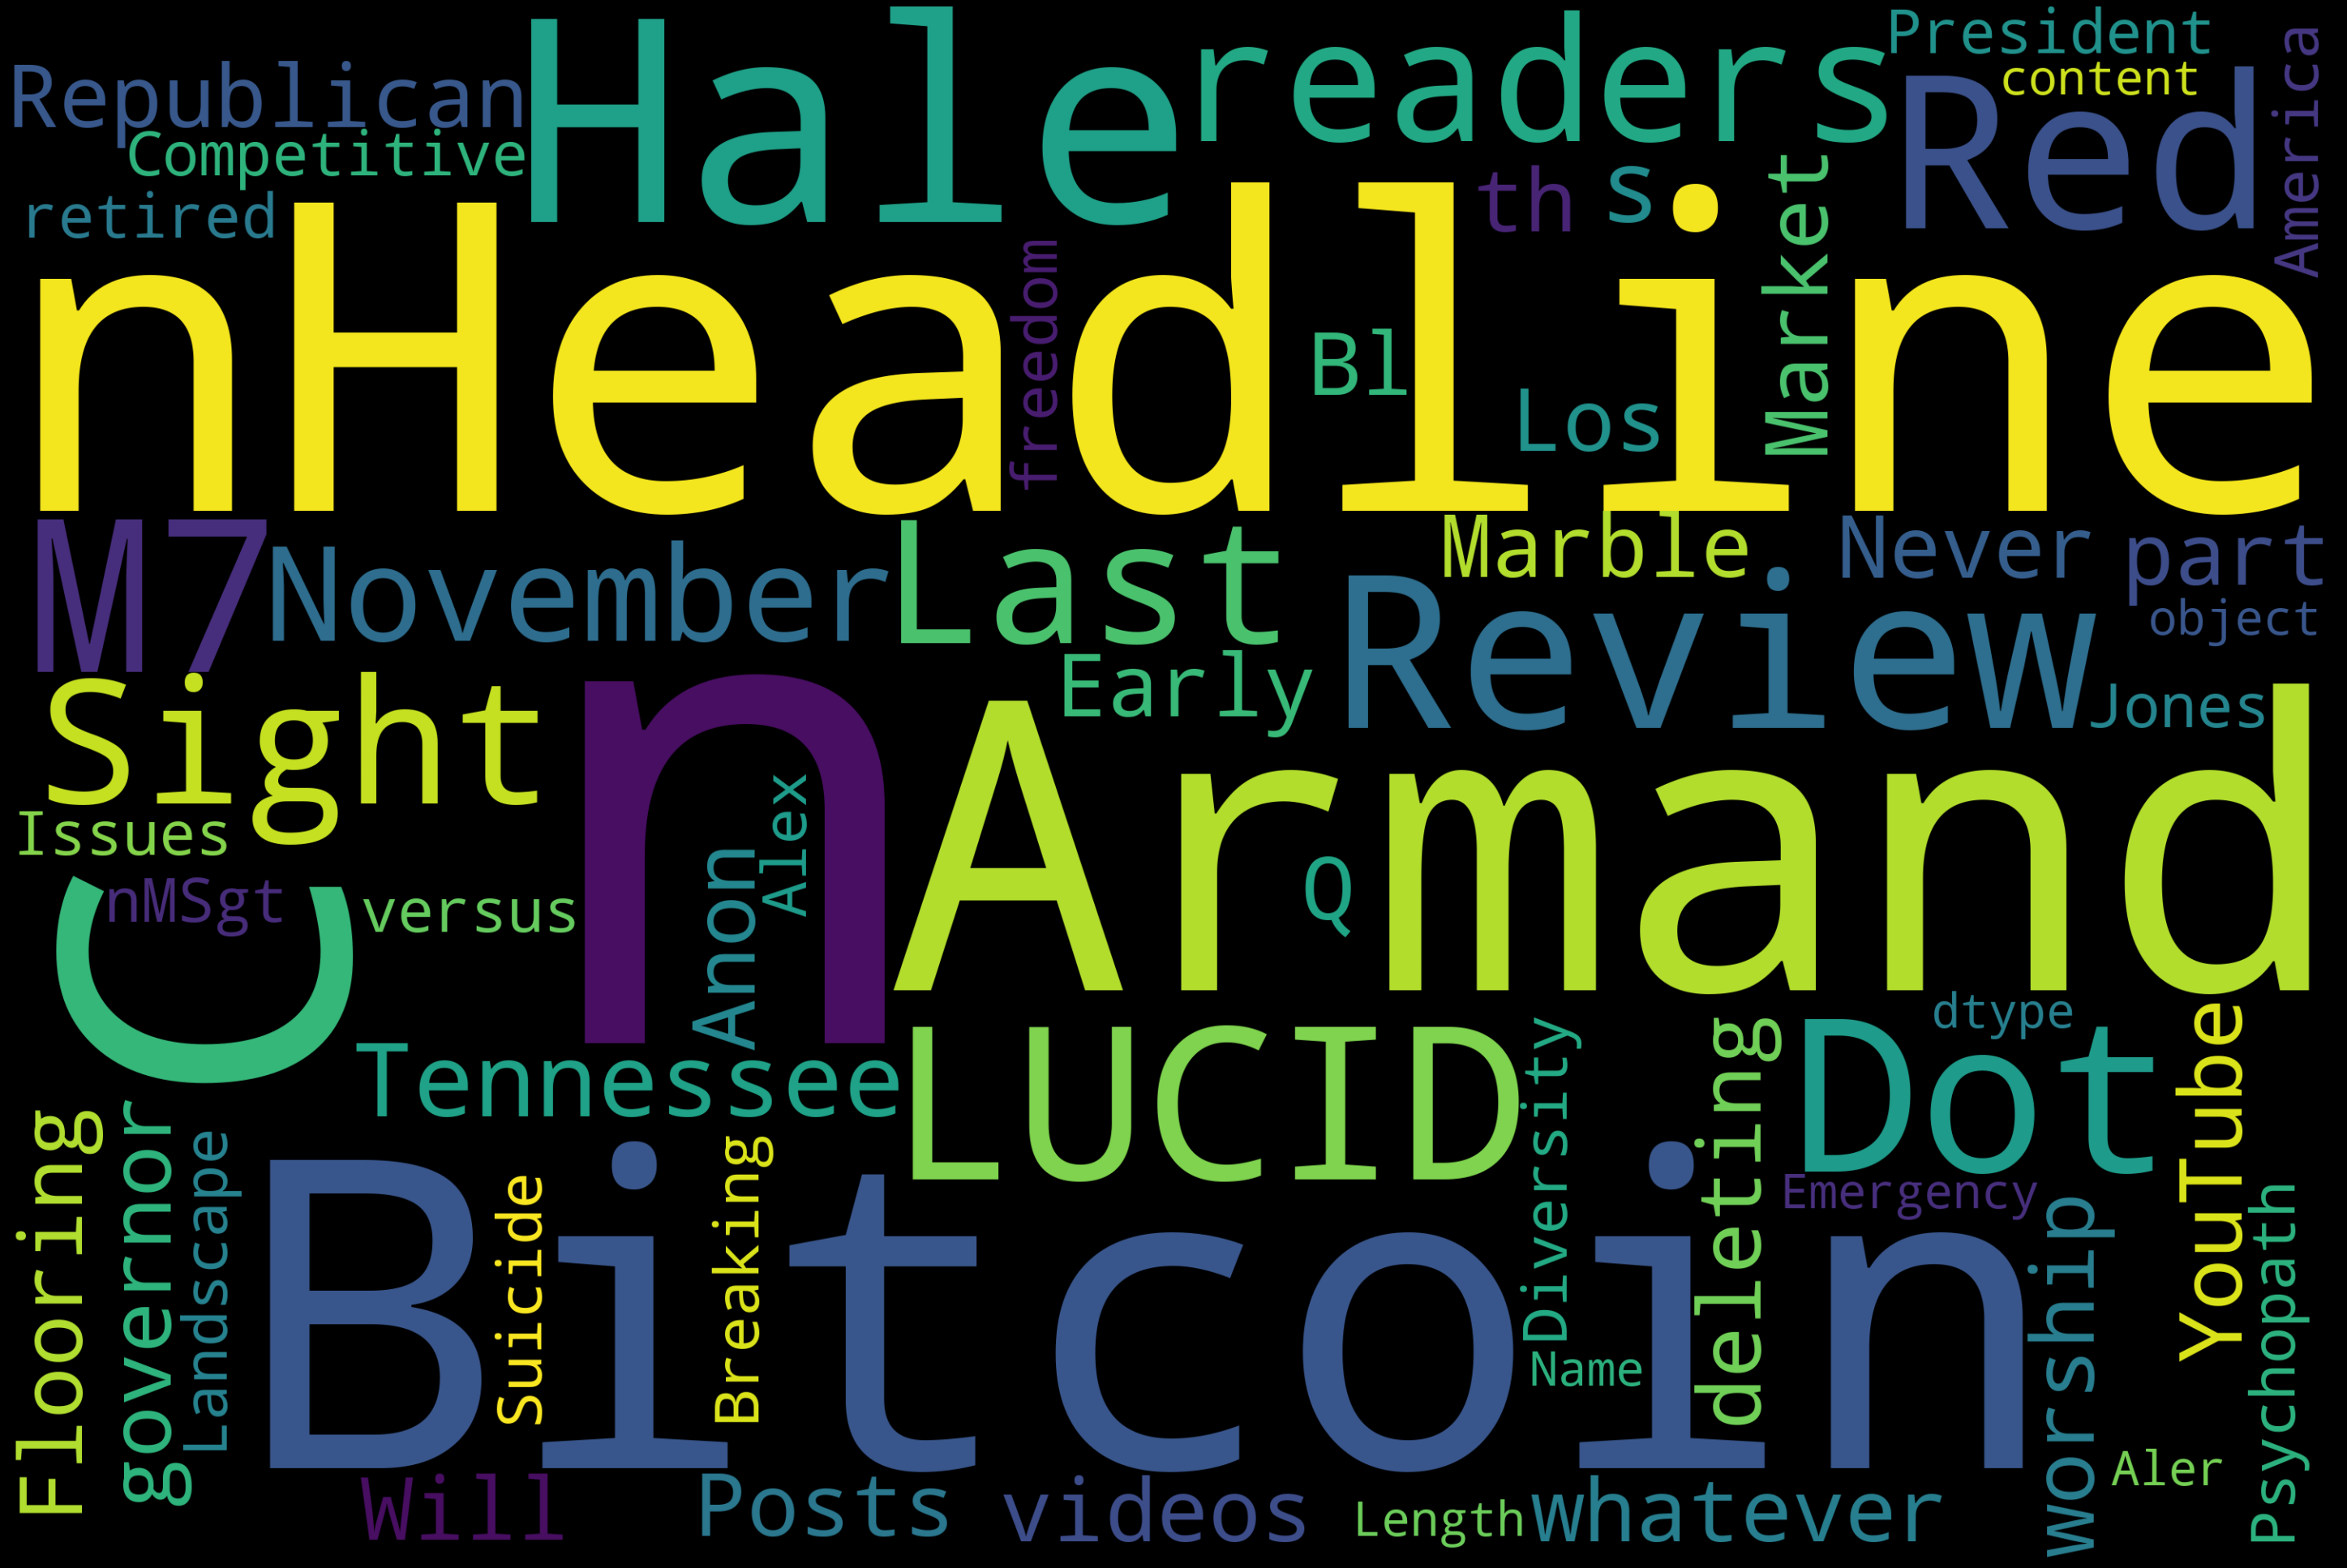

In [98]:
text = df_news_chunk["content"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [54]:
df_news_chunk['type'].value_counts()

unreliable    217
conspiracy    149
clickbait     136
fake          124
satire        112
hate           99
political      62
reliable       58
bias           21
junksci        17
rumor           1
unknown         1
Name: type, dtype: int64

In [8]:
"""
with tqdm() as progress:
    for df_news_chunk in pd.read_csv(path_news_csv, encoding='utf-8', engine='python', chunksize=1000):
        progress.update()
        
"""

"\nwith tqdm() as progress:\n    for df_news_chunk in pd.read_csv(path_news_csv, encoding='utf-8', engine='python', chunksize=1000):\n        progress.update()\n        \n"

In [9]:
def news_generator():
    with tqdm() as progress:
        for df_news_chunk in pd.read_csv(path_news_csv, encoding='utf-8', engine='python', chunksize=10 * 1000):
            news_filter = df_news_chunk.type.isin(set(['fake', 'conspiracy', 'unreliable', 'reliable']))
            df_news_chunk_filtered = df_news_chunk[news_filter]
            for row in df_news_chunk_filtered.itertuples():
                label = 1 if row.type == 'reliable' else 0

                progress.update()
                yield int(row.id), '%s %s' % (row.title, row.content), label

In [10]:
lens = []
for i, (_id, con, label) in enumerate(news_generator()):
    if i > 10 * 1000:
        break

    lens.append(len(con))

10002it [00:03, 3267.37it/s]


In [11]:
len(lens), sum(lens) / len(lens), max(lens), min(lens)


(10001, 4767.068493150685, 100091, 59)

/Users/swen/.pyenv/versions/3.9.7/envs/artefact/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

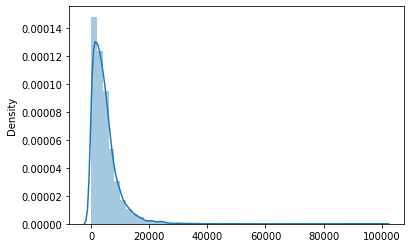

In [53]:
sns.distplot(lens)


In [13]:
with tqdm() as progress:
    
    for k in range(5000000):
        progress.update()

5000000it [00:05, 999778.27it/s] 


In [14]:
import multiprocess

In [15]:
# changement ici de multiprocessing en multiprocess
def _preprocess_string(news):
    _id, con, label = news
    return _id, preprocess_string(con), label

def news_preprocessed_generator():
    missing_words = {}
    
    with multiprocess.Pool(multiprocess.cpu_count(), maxtasksperchild=1) as pool:
        for _id, con, label in pool.imap(_preprocess_string, news_generator(), chunksize=1000):
            yield _id, con, label, missing_words

In [16]:
from p_tqdm import p_map


In [17]:
all_missing_words = {}
with open(path_news_preprocessed, 'w') as out_news_embedded:
    for _id, con, label, missing_words in news_preprocessed_generator():
        out_news_embedded.write(ujson.dumps({
            'id': _id, 'content': con, 'label': int(label)
        }) + '\n')
        all_missing_words.update(missing_words)

3937987it [3:22:44, 323.73it/s] 


In [82]:
!shuf /Users/swen/Downloads/FakeNewsCorpus_1_0/news_cleaned_2018_02_13.preprocessed.jsonl > \
       Users/swen/Downloads/FakeNewsCorpus_1_0/news_cleaned_2018_02_13.preprocessed.shuffled.jsonl

zsh:1: no such file or directory: Users/swen/Downloads/FakeNewsCorpus_1_0/news_cleaned_2018_02_13.preprocessed.shuffled.jsonl


In [58]:
import pandas as pd
import json
path_news_preprocessed
#df = pd.read_json('/Users/swen/Downloads/FakeNewsCorpus-1.0/news_cleaned_2018_02_13.preprocessed.jsonl', orient='split')
with open(path + 'news_cleaned_2018_02_13.preprocessed.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list:
    result = json.loads(json_str)
    print(f"result: {result}")
    print(isinstance(result, dict))

result: {'id': 11, 'content': ['back', 'polic', 'massacr', 'haitian', 'impun', 'back', 'polic', 'massacr', 'haitian', 'impun', '“when', 'polic', 'final', 'left', 'campu', 'civilian', 'lai', 'dead', 'courtyard', 'shot', 'head', 'clock', 'morn', 'novemb', 'haitian', 'polic', 'offic', 'raid', 'grand', 'ravin', 'area', 'port', 'princ', 'seri', 'loud', 'explos', 'follow', 'gunfir', 'hour', 'commot', 'didn’t', 'stop', 'neighborhood', 'sieg', 'start', 'anti', 'gang', 'oper', 'poor', 'larg', 'forgotten', 'neighborhood', 'poor', 'larg', 'forgotten', 'countri', 'end', 'summari', 'execut', 'innoc', 'civilian', 'school', 'campu', 'polic', 'offic', 'work', 'unit', 'nation', 'mission', 'justic', 'support', 'haiti', 'launch', 'octob', 'reboot', 'previou', 'mission', 'begun', 'thousand', 'troop', 'sent', 'haiti', 'follow', 'coup', 'd’etat', 'task', 'restor', 'stabil', 'reinforc', 'nation', 'polic', 'capac', 'mission', 'issu', 'statement', 'dai', 'raid', 'call', 'prompt', 'investig', 'haitian', 'author


KeyboardInterrupt



In [70]:
count_lines = 0
with open(path_news_preprocessed, 'r') as in_news:
    for line in tqdm(in_news):
        count_lines += 1

3937987it [03:19, 19754.99it/s] 


In [71]:
count_lines, int(count_lines * .8), int(count_lines * .1), \
    count_lines - (int(count_lines * 0.8) + int(count_lines * 0.1))

(3937987, 3150389, 393798, 393800)

In [72]:
train_size = int(count_lines * .8)
test_size = int(count_lines * .8)
val_size = count_lines - (int(count_lines * 0.8) + int(count_lines * 0.1))

In [73]:
with open(path_news_preprocessed, 'r') as in_news:
    with open(path_news_train, 'w') as out_train:
        with open(path_news_test, 'w') as out_test:
            with open(path_news_val, 'w') as out_val:
                for i, line in tqdm(enumerate(in_news)):
                    if i < count_lines * .8:
                        out_train.write(line)
                    elif i < count_lines * .9:
                        out_test.write(line)
                    else:
                        out_val.write(line)

3937987it [03:12, 20468.89it/s]


In [25]:
max_words = 200

In [74]:
def _news_generator_process_line(line):
    article = ujson.loads(line)

    embedding = np.zeros((max_words, 100))
    for i, word in enumerate(article['content'][:max_words]):
        if word in FastText:
            embedding[i] = FastText[word]
            
    return embedding, article['label']

def news_generator(path, batch):
    while True:
        with open(path_news_shuffled, 'r') as in_news:
            # with multiprocessing.Pool(2) as pool:
            batch_i = 0
            batch_embedding = np.zeros((batch, max_words, 100))
            batch_label = np.zeros((batch, 1))
            for line in in_news:
                embedding, label = _news_generator_process_line(line)
                
                if (batch_i + 1) == batch:
                    yield batch_embedding, batch_label
                    batch_embedding = np.zeros((batch, max_words, 100))
                    batch_label = np.zeros((batch, 1))
                    batch_i = 0
                else:
                    batch_embedding[batch_i] = embedding
                    batch_label[batch_i, 0] = label
                    batch_i += 1